# GIC Model Generation

Demonstrates building the full GIC linear model from PowerWorld case data, including
the G-matrix, H-matrix, and per-unit zeta model.

Topics covered:
- GIC configuration and options
- Building the linear GIC model with `model()`
- Inspecting G-matrix (conductance Laplacian)
- Inspecting H-matrix (linear GIC function)
- Comparing model G-matrix with PowerWorld's G-matrix
- Applying storms and validating model predictions

In [1]:
import numpy as np
from esapp import GridWorkBench
from esapp.components import Bus, Branch, Substation, GICXFormer
from esapp.utils import format_plot

In [2]:
# This cell is hidden in the documentation.
import ast

with open('../data/case.txt', 'r') as f:
    case_path = ast.literal_eval(f.read().strip())

wb = GridWorkBench(case_path)

'open' took: 3.7524 sec


In [3]:
# Plotting functions (hidden from documentation)
import sys; sys.path.insert(0, "..")
from plot_helpers import (
    plot_spy_matrices, plot_gmatrix_comparison,
    plot_gic_bar_hist,
)

## 1. GIC Configuration

Before building a GIC model, configure the GIC options. The `configure()` method
sets sensible defaults.

In [4]:
wb.gic.configure(pf_include=True, ts_include=False, calc_mode='SnapShot')

# View current settings
settings = wb.gic.settings()
print("GIC Settings:")
print(settings.to_string(index=False))

GIC Settings:
                        VariableName        ValueField
                 AutoXFMaxTurnsRatio                 4
                            BusNoSub None (Ungrounded)
              CalcInducedDCVoltEquiv                NO
             CalcInducedDCVoltLength                 1
               CalcInducedDCVoltLowR                NO
                    CalcMaxDirection               YES
                            CalcMode          SnapShot
                 DistXFConfigDefault              GWye
                   EField3dFileMerge               YES
                EField3dFileMultLoad                 0
           EField3dFileNewNamePrompt                NO
                         EfieldAngle                90
                   EFieldEventsCount                 0
             EFieldEventsCountActive                 0
             EFieldEventsfB3DSaveAll               YES
        EFieldEventsRefDateTimeLocal                  
          EFieldEventsRefDateTimeUTC               

## 2. Building the GIC Model

The `model()` method extracts substation, bus, branch, transformer, and generator
data from the case and computes all GIC matrices.

In [5]:
wb.gic.model()

print(f"Incidence matrix (A): {wb.gic.A.shape}  (branches x nodes)")
print(f"G-matrix:             {wb.gic.G.shape}  (nodes x nodes)")
print(f"H-matrix:             {wb.gic.H.shape}  (transformers x branches)")
print(f"Zeta (per-unit):      {wb.gic.zeta.shape}")
print(f"Effective operator:   {wb.gic.eff.shape}")
print(f"Bus permutation (Px): {wb.gic.Px.shape}")

Incidence matrix (A): (140, 68)  (branches x nodes)
G-matrix:             (68, 68)  (nodes x nodes)
H-matrix:             (12, 140)  (transformers x branches)
Zeta (per-unit):      (12, 140)
Effective operator:   (12, 140)
Bus permutation (Px): (37, 12)


## 3. Matrix Sparsity Patterns

Visualize the sparsity structure of the GIC matrices using spy plots.

In [ ]:
plot_spy_matrices(
    [wb.gic.A, wb.gic.G, wb.gic.H],
    [f'Incidence Matrix A\n{wb.gic.A.shape}, nnz={wb.gic.A.nnz}',
     f'G-Matrix (Conductance Laplacian)\n{wb.gic.G.shape}, nnz={wb.gic.G.nnz}',
     f'H-Matrix (GIC Function)\n{wb.gic.H.shape}, nnz={wb.gic.H.nnz}'])

## 5. Storm Application and GIC Results

Apply a uniform electric field storm and examine the resulting transformer GICs.

In [8]:
# Apply 1 V/km eastward storm
wb.gic.storm(1.0, 90)

gic_results = wb[GICXFormer, ['BusNum3W', 'BusNum3W:1', 'GICXFNeutralAmps']]
gic_sorted = gic_results.reindex(
    gic_results['GICXFNeutralAmps'].abs().sort_values(ascending=False).index
)

print(f"Total transformers: {len(gic_results)}")
print(f"Max |GIC|: {gic_results['GICXFNeutralAmps'].abs().max():.3f} A")
print(f"\nTop transformers:")
print(gic_sorted.head(10).to_string(index=False))

Total transformers: 12
Max |GIC|: 15.440 A

Top transformers:
 BusNum3W  BusNum3W:1  BusNum3W:2  BusNum3W:5  GICXFNeutralAmps LineCircuit
        9          10           0          10         15.439837           1
        5           6           0           6         13.443257           1
       14          15           0          15         12.639866           1
       14          15           0          15         12.639866           2
        1           2           0           2          0.753270           1
        1           2           0           2          0.753270           2
        1           2           0           2          0.753270           3
       25          26           0          26         -0.407258           1
       25          26           0          26         -0.407258           2
       22          23           0          23         -0.009016           1


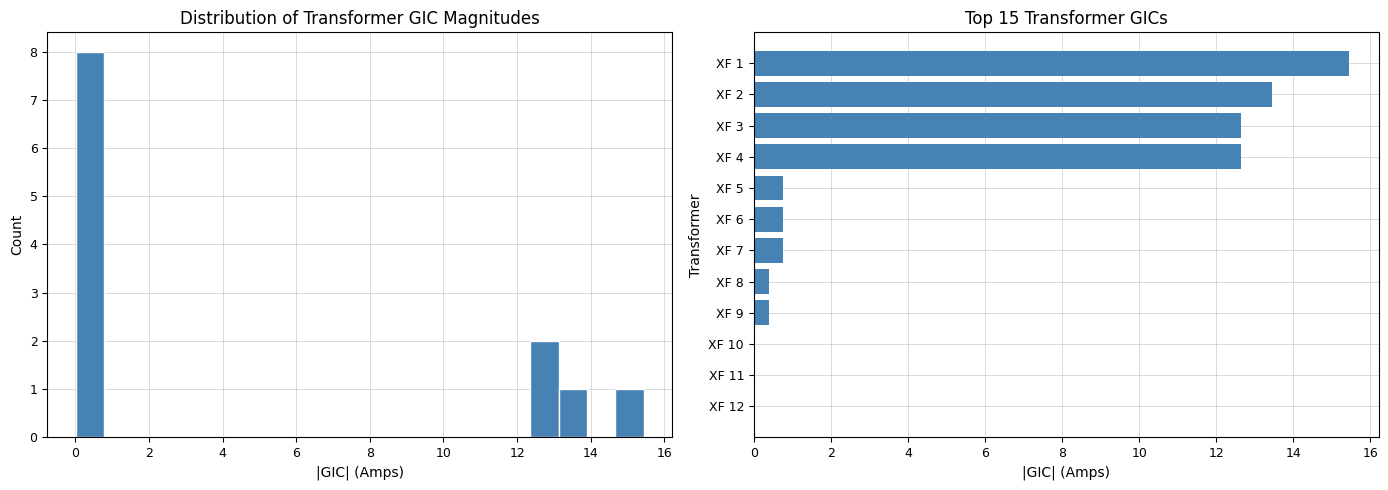

In [9]:
gic_abs = gic_results['GICXFNeutralAmps'].abs()
plot_gic_bar_hist(gic_abs)

## 6. Per-Unit Zeta Model

The zeta matrix converts the linear GIC model to per-unit form, suitable
for integration into power flow studies. Each row represents a transformer's
contribution to reactive power losses.

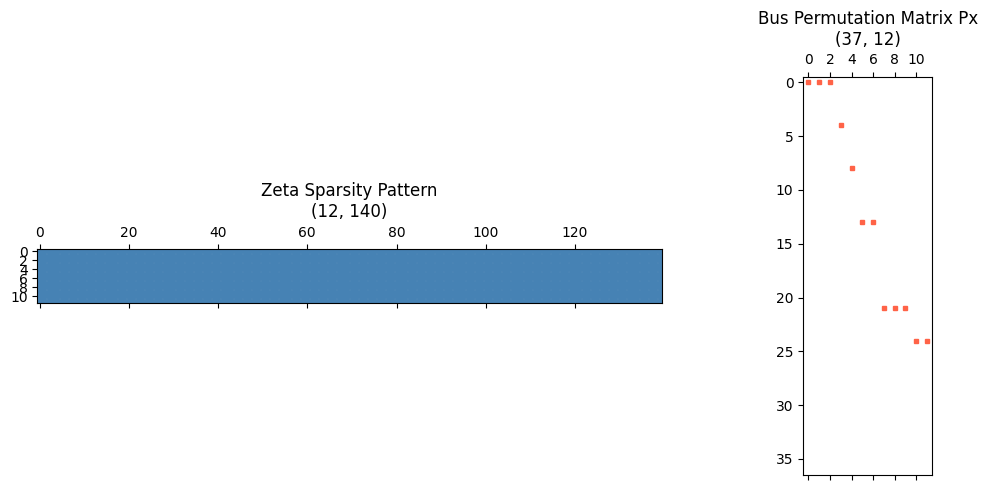

In [10]:
plot_spy_matrices(
    [wb.gic.zeta, wb.gic.Px],
    [f'Zeta Sparsity Pattern\n{wb.gic.zeta.shape}',
     f'Bus Permutation Matrix Px\n{wb.gic.Px.shape}'],
    colors=['steelblue', 'tomato'])

## Summary

The GIC linear model provides:
- **G-matrix**: Conductance Laplacian of the GIC network (A.T @ Gd @ A + Gs)
- **H-matrix**: Maps induced line voltages to transformer neutral currents
- **Zeta**: Per-unit model for power flow integration
- **Px**: Maps transformers to their loss-modeling buses

These matrices enable fast GIC sensitivity analysis without re-running
PowerWorld for each E-field scenario.